In [71]:
import torch
import torch.nn as nn
from sklearn.datasets import make_circles,make_moons
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [72]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dimension: int):
        super().__init__()
        self.in_dimension=in_dimension
        self.linear=nn.Linear(in_dimension,1)
        self.sigmoid=nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sigmoid(self.linear(x))

class Classifier(nn.Module):
    def __init__(self, in_dimension: int, hidden_dimension, out_dimension, bias=True):
        super().__init__()
        self.in_layer=nn.Linear(in_dimension,hidden_dimension)
        self.hidden_layer=nn.Linear(hidden_dimension,hidden_dimension)
        self.out_layer=nn.Linear(hidden_dimension,out_dimension)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x=self.in_layer(x)
        x=torch.relu(x)
        x=self.hidden_layer(x)
        x=torch.relu(x)
        x=self.out_layer(x)
        return x

In [73]:
def linear_dataset(n_per_class=250):
    x1_points=np.linspace(-1,1,n_per_class)
    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        sf_x=np.random.randint(2,10)
        sf_y=np.random.choice(np.arange(2,4))
        x[2*k,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,0.5+(2*np.random.random()-1)/sf_y]
        x[2*k+1,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,-0.5+(2*np.random.random()-1)/sf_y]
        y[2*k+1]=1

    for k in range(x.shape[0]):
        if y[k]==1:
            x[k,1]=(x[k,1]-1)/2
        else:
            x[k,1]=(x[k,1]+1)/2
    return x,y,'Linear Dataset'

def vee_dataset(n_per_class=250):
    x_points=np.linspace(-1,1,n_per_class)

    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        x[2*k,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)]
        x[2*k+1,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)+0.5]
        y[2*k+1]=1
    return x,y,'Vee-Shaped Dataset'

def circles_dataset(n_per_class=250):
    data=make_circles(2*n_per_class,noise=0.05,factor=0.5)
    x=data[0]
    y=data[1]
    return x,y,'Circles Dataset'

def curved_dataset(n_per_class=250):
    data=make_moons(2*n_per_class,noise=0.1)
    x=data[0]
    y=data[1]
    return x,y,'Curved Dataset'

In [81]:
def linearity_score(x,y,dataset_name,num_epochs=500,batch_size=16,lr=1e-3,plot=False):
    dataset_size=x.shape[0]
    model=LinearClassifier(2)
    opt=torch.optim.Adam(model.parameters(),lr=lr)
    criterion=nn.BCELoss()

    progress_bar=tqdm(range(num_epochs))
    for epoch in progress_bar:
        epoch_cycles=dataset_size//batch_size
        epoch_loss=0
        for cycle in range(epoch_cycles+1):
            if cycle==epoch_cycles:
                inputs=x[-cycle*batch_size:,:]
                targets=y[-cycle*batch_size:]
            else:
                inputs=x[cycle*batch_size:(cycle+1)*batch_size,:]
                targets=y[cycle*batch_size:(cycle+1)*batch_size]
            opt.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs,targets)
            loss.backward()
            opt.step()
            epoch_loss+=loss*len(targets)
        progress_bar.set_description(f'Training Binary Classifier: epoch {epoch+1}/{num_epochs}, loss={epoch_loss/dataset_size:.4f}')

    cav=model.linear.weight.detach()[0]
    cav_norm=torch.norm(cav,p=2).item()
    cav=cav/cav_norm
    bias=model.linear.bias.detach()

    classifier_model=Classifier(2,16,2)
    classifier_opt=torch.optim.Adam(classifier_model.parameters(),lr=lr)
    classifier_criterion=nn.CrossEntropyLoss()

    y=y.type(torch.int64)

    progress_bar=tqdm(range(num_epochs))
    for epoch in progress_bar:
        epoch_cycles=dataset_size//batch_size
        epoch_loss=0
        for cycle in range(epoch_cycles+1):
            if cycle==epoch_cycles:
                inputs=x[-cycle*batch_size:,:]
                targets=y[-cycle*batch_size:]
            else:
                inputs=x[cycle*batch_size:(cycle+1)*batch_size,:]
                targets=y[cycle*batch_size:(cycle+1)*batch_size]
            classifier_opt.zero_grad()
            outputs=classifier_model(inputs)
            loss=classifier_criterion(outputs,targets.squeeze(1))
            loss.backward()
            classifier_opt.step()
            epoch_loss+=loss*len(targets)
        progress_bar.set_description(f'Training Classifier: epoch {epoch+1}/{num_epochs}, loss={epoch_loss/dataset_size:.4f}')
    
    class_zero=x[(y==0).T[0],:]
    class_one=x[(y==1).T[0],:]

    pairs=-np.ones(class_one.shape[0],dtype=int)
    pairs_distances=-np.ones(class_one.shape[0])

    for k in range(class_zero.shape[0]):
        distances=np.zeros(class_one.shape[0])
        for l in range(class_one.shape[0]):
            distances[l]=np.sqrt((class_zero[k,0]-class_one[l,0])**2+(class_zero[k,1]-class_one[l,1])**2)
        min_dist_idx=np.argmin(distances)
        min_dist=distances[min_dist_idx]
        if pairs_distances[min_dist_idx]==-1:
            pairs_distances[min_dist_idx]=min_dist
            pairs[min_dist_idx]=k
        elif min_dist<pairs_distances[min_dist_idx]:
            pairs_distances[min_dist_idx]=min_dist
            pairs[min_dist_idx]=k
        
    pairs=np.array([(positive_idx,negative_idx) for positive_idx,negative_idx in enumerate(pairs) if negative_idx>-1])
    distances=pairs_distances[pairs_distances>-1]

    positive_category_idxs=np.array([idx[0] for idx in pairs])
    negative_category_idxs=np.array([idx[1] for idx in pairs])

    negative_category_idxs_argsort=np.argsort(negative_category_idxs)

    pairs_sorted=pairs[negative_category_idxs_argsort]
    positive_category_idxs_sorted=positive_category_idxs[negative_category_idxs_argsort]
    negative_category_idxs_sorted=negative_category_idxs[negative_category_idxs_argsort]
    distances_sorted=distances[negative_category_idxs_argsort]

    negative_category_relative_idx=0

    cav_sfs=[]

    for k in range(class_zero.shape[0]):
        if k in negative_category_idxs_sorted:

            original_model_output=classifier_model(class_zero[k,:])
            cav_sf=0
            perturbed_model_output = classifier_model(class_zero[k,:])

            while perturbed_model_output.argmax()==0 and cav_sf<5:
                cav_sf+=0.005
                perturbed_model_output = classifier_model(class_zero[k,:]+cav_sf*cav)
            cav_sfs.append(cav_sf)
            negative_category_relative_idx+=1

    normal_sfs=[]
    normals=[]

    dots=[]

    negative_category_relative_idx=0

    for k in range(class_zero.shape[0]):
        if k in negative_category_idxs_sorted:

            positive_category_idx=positive_category_idxs_sorted[negative_category_relative_idx]

            normal=class_one[positive_category_idx,:]-class_zero[k,:]
            normal=normal/np.linalg.norm(normal)
            normals.append(normal)

            dots.append(np.dot(normal,cav))

            original_model_output=classifier_model(class_zero[k,:])
            norm_sf=0
            perturbed_model_output = classifier_model(class_zero[k,:])

            while perturbed_model_output.argmax()==0 and norm_sf<5:
                norm_sf+=0.005
                perturbed_model_output = classifier_model(class_zero[k,:]+norm_sf*normal)
            normal_sfs.append(norm_sf)
            negative_category_relative_idx+=1

    linearity_score=0
    count=0
    for k in range(len(cav_sfs)):
        count+=1
        
        cav_sf=cav_sfs[k]
        norm_sf=normal_sfs[k]
        dot=dots[k]
        linearity_score+=np.sqrt(cav_sf**2+norm_sf**2-2*cav_sf*norm_sf*dot)/distances_sorted[k]
    linearity_score=linearity_score/count
       
    if plot:
        colors=plt.cm.jet([0,0.1,0.9,1])
        fig,axs=plt.subplots(nrows=1,ncols=1)
        resolution=100
        model_outputs=np.zeros((resolution**2))
        xs=np.zeros((resolution**2,2))
        for n,x1 in enumerate(np.linspace(min(x[:,0]),max(x[:,0]),resolution)):
            for m,x2 in enumerate(np.linspace(min(x[:,1]),max(x[:,1]),resolution)):
                model_outputs[n*resolution+m]=classifier_model(torch.tensor([x1,x2]).float()).argmax()
                xs[resolution*n+m,:]=[x1,x2]

        #axs.scatter(xs[model_outputs==1,0],xs[model_outputs==1,1],alpha=0.5,s=1,color=colors[1])
        #axs.scatter(xs[model_outputs==0,0],xs[model_outputs==0,1],alpha=0.5,s=1,color=colors[2])
        axs.scatter(x[y.T[0]==0,0],x[y.T[0]==0,1],s=5,color=colors[3])
        axs.scatter(x[y.T[0]==1,0],x[y.T[0]==1,1],s=5,color=colors[0])

        for l,pair in enumerate(pairs_sorted):
            point_zero=class_zero[pair[1],:]
            point_one=class_one[pair[0],:]
            if l==0:
                axs.plot([point_zero[0],point_one[0]],[point_zero[1],point_one[1]],color='black',label='Boundary Normal')
                axs.plot([point_zero[0],point_zero[0]+cav[0]*cav_sfs[l]],[point_zero[1],point_zero[1]+cav[1]*cav_sfs[l]],color='blue',label='CAV Perturbation')
                axs.plot([point_zero[0],point_zero[0]+normals[l][0]*normal_sfs[l]],[point_zero[1],point_zero[1]+normals[l][1]*normal_sfs[l]],color='red',label='Boundary Normal Perturbation')
            else:
                axs.plot([point_zero[0],point_one[0]],[point_zero[1],point_one[1]],color='black')
                axs.plot([point_zero[0],point_zero[0]+cav[0]*cav_sfs[l]],[point_zero[1],point_zero[1]+cav[1]*cav_sfs[l]],color='blue')
                axs.plot([point_zero[0],point_zero[0]+normals[l][0]*normal_sfs[l]],[point_zero[1],point_zero[1]+normals[l][1]*normal_sfs[l]],color='red')

        axs.legend()
        axs.set_title(f'{dataset_name}: Linearly Separated Score {linearity_score:.4f}')

    return linearity_score

Training Binary Classifier: epoch 500/500, loss=1.3752: 100%|██████████| 500/500 [00:10<00:00, 47.07it/s]
Training Classifier: epoch 500/500, loss=0.0000: 100%|██████████| 500/500 [00:29<00:00, 17.23it/s]


10.34298673185103

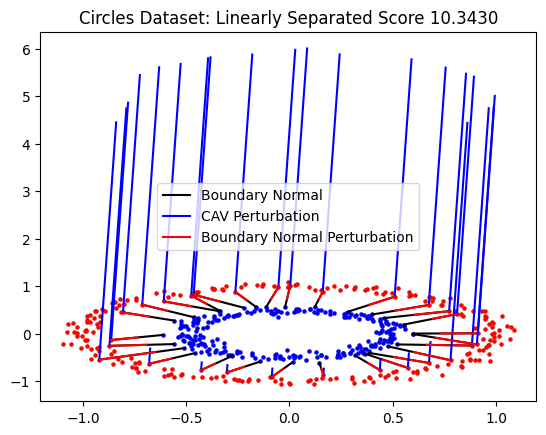

In [87]:
x,y,dataset_name=circles_dataset()

x=torch.tensor(x).float()
y=torch.tensor(y).float().unsqueeze(1)

linearity_score(x,y,dataset_name,plot=True)